In [1]:
# import the necessary packages
import numpy as np
import imutils
import time
import cv2
import os
import glob

#yolov3 pytorch
from sys import platform
from models import *
from utils.datasets import *
from utils.utils import *

In [135]:
### DETECTION FUNCTION - START ###

def detect(im0,
			cfg = "prod_model/yolov3-tiny.cfg",
			weights = "prod_model/yolov3-tiny_final-TL.weights",
			conf_thres = 0.5,
			nms_thres = 0.5):

	img, *_ = letterbox(im0, new_shape=416)
	im0_shape = img.shape

	# Normalize RGB
	img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
	img = np.ascontiguousarray(img, dtype=np.float32)  # uint8 to float32
	img /= 255.0  # 0 - 255 to 0.0 - 1.0

	device = torch_utils.select_device()
	torch.backends.cudnn.benchmark = False  # set False for reproducible results

	model = Darknet(cfg, 416)

	_ = load_darknet_weights(model, weights)

	# Fuse Conv2d + BatchNorm2d layers
	model.fuse()

	# Eval mode
	model.to(device).eval()

	# Get detections
	img = torch.from_numpy(img).unsqueeze(0).to(device)
	pred, _ = model(img)
	det = non_max_suppression(pred, conf_thres, nms_thres)[0]

	print(det)
	if det is not None and len(det) > 0:
		# Rescale boxes from 416 to true image size
		det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

	if det is not None:
		return det.detach().numpy()

	return None

In [92]:
def im0_to_img(im0):
    img, *_ = letterbox(im0, new_shape=416)
    #img = img[:, :, ::-1]
    img = img.transpose(2, 0, 1)# BGR to RGB
    img = np.ascontiguousarray(img, dtype=np.float32)  # uint8 to float32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    return img

In [27]:
import os
os.listdir('../yolov3/data/samples/')

['zidane.jpg', 'bus.jpg']

In [119]:
from PIL import Image
img_dir = '../yolov3/data/samples/bus.jpg'
img = cv2.imread(img_dir)
img_np = np.array(img)

In [125]:
detect(img_np)

Using CPU

tensor([[ 42.49237, 153.35626,  63.28904, 182.67477,   0.99153,   1.00000,   0.00000],
        [103.67844, 155.76172, 121.63810, 181.72729,   0.97818,   1.00000,   0.00000]], grad_fn=<IndexBackward>)


/Users/See/anaconda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


array([[        100,         398,         154,         474,     0.99153,           1,           0],
       [        259,         404,         305,         472,     0.97818,           1,           0]], dtype=float32)

In [134]:
import argparse
import time
from sys import platform

from models import *
from utils.datasets import *
from utils.utils import *


def detect(
        cfg,
        data_cfg,
        weights,
        images='data/samples',  # input folder
        output='output',  # output folder
        fourcc='mp4v',
        img_size=416,
        conf_thres=0.5,
        nms_thres=0.5,
        save_txt=False,
        save_images=False,
        webcam=False,
        display=True
):
    device = torch_utils.select_device()
    torch.backends.cudnn.benchmark = False  # set False for reproducible results

    if os.path.exists(output):
        shutil.rmtree(output)  # delete output folder
    os.makedirs(output)  # make new output folder

    model = Darknet(cfg, img_size)

    # Load weights
    _ = load_darknet_weights(model, weights)

    # Fuse Conv2d + BatchNorm2d layers
    model.fuse()

    # Eval mode
    model.to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        save_images = False
        dataloader = LoadWebcam(img_size=img_size)
    else:
        dataloader = LoadImages(images, img_size=img_size)

    # Get classes and colors
    #classes = load_classes(parse_data_cfg(data_cfg)['names'])
    #colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(classes))]

    for i, (path, img, im0, vid_cap) in enumerate(dataloader):
        
        #swapout img and im0
        im0 = img_np
        pre_img = img
        
        t = time.time()

        # Get detections
        img = torch.from_numpy(img).unsqueeze(0).to(device)
        pred, _ = model(img)
        det = non_max_suppression(pred, conf_thres, nms_thres)[0]
        print('post_nms: {}'.format(det))

        if det is not None and len(det) > 0:
            # Rescale boxes from 416 to true image size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            # Print results to screen
            print('%gx%g ' % img.shape[2:], end='')  # print image size
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()
                print('%g %ss' % (n, 'head'))

            # Draw bounding boxes and labels of detections
            for *xyxy, conf, cls_conf, cls in det:
                print(*xyxy)
                if save_txt:  # Write to file
                    with open(save_path + '.txt', 'a') as file:
                        file.write(('%g ' * 6 + '\n') % (*xyxy, cls, conf))

                # Add bbox to the image
                label = '%.2f' % (conf)
                plot_one_box(xyxy, im0, label=label, color=[100,100,100])
                centre_x = (xyxy[0] + xyxy[2])/2
                centre_y = (xyxy[1] + xyxy[3])/2
                print(type(xyxy))
                cv2.circle(im0,(centre_x,centre_y), 2, (0,0,255), -1)
                cv2.rectangle(im0, (xyxy[0],xyxy[1]), (xyxy[2],xyxy[3]), (0,0,255), 2) 
    return pre_img

In [42]:
result = detect(cfg = "prod_model/yolov3-tiny.cfg",
       data_cfg = 'data/coco.data',
       weights = "prod_model/yolov3-tiny_final-TL.weights",
        images = img_dir)

Using CPU

image 1/1 ../yolov3/data/samples/bus.jpg: post_nms: tensor([[ 42.49237, 153.35626,  63.28904, 182.67477,   0.99153,   1.00000,   0.00000],
        [103.67844, 155.76172, 121.63810, 181.72729,   0.97818,   1.00000,   0.00000]], grad_fn=<IndexBackward>)
416x320 2 heads
tensor(100., grad_fn=<SelectBackward>) tensor(398., grad_fn=<SelectBackward>) tensor(154., grad_fn=<SelectBackward>) tensor(474., grad_fn=<SelectBackward>)
<class 'list'>
tensor(259., grad_fn=<SelectBackward>) tensor(404., grad_fn=<SelectBackward>) tensor(305., grad_fn=<SelectBackward>) tensor(472., grad_fn=<SelectBackward>)
<class 'list'>


/Users/See/anaconda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [110]:
A = result
B = im0_to_img(img_np)

np.array_equal(A,B)

False

In [94]:
A.shape

(3, 416, 320)

In [95]:
B.shape

(3, 416, 320)

In [101]:
A_0 = A[0,:,:]
B_0 = B[0,:,:]

np.array_equal(A_0,B_0)

False

In [85]:
import matplotlib.pyplot as plt

In [44]:
result.shape

(3, 416, 320)

In [45]:
d_result = im0_to_img(img_np)

In [54]:
d_result.shape

(3, 416, 320)

In [55]:
np.array_equal(d_result, result)

False

In [103]:
bingo_list = []
c, h, w = A.shape
for c_i in range(c):
    for h_i in range(h):
        for w_i in range(w):
            if A[c_i,h_i,w_i]!=B[c_i,h_i,w_i]:
                bingo_list.append([c_i, h_i, w_i])
            

In [104]:
len(bingo_list)

105406

In [105]:
bingo_list

[[0, 0, 18],
 [0, 0, 33],
 [0, 0, 40],
 [0, 0, 58],
 [0, 0, 67],
 [0, 0, 73],
 [0, 0, 80],
 [0, 0, 81],
 [0, 0, 88],
 [0, 0, 102],
 [0, 0, 106],
 [0, 0, 110],
 [0, 0, 117],
 [0, 0, 119],
 [0, 0, 121],
 [0, 0, 127],
 [0, 0, 138],
 [0, 0, 139],
 [0, 0, 140],
 [0, 0, 141],
 [0, 0, 142],
 [0, 0, 145],
 [0, 0, 151],
 [0, 0, 152],
 [0, 0, 155],
 [0, 0, 156],
 [0, 0, 158],
 [0, 0, 161],
 [0, 0, 164],
 [0, 0, 165],
 [0, 0, 166],
 [0, 0, 169],
 [0, 0, 170],
 [0, 0, 174],
 [0, 0, 176],
 [0, 0, 178],
 [0, 0, 179],
 [0, 0, 180],
 [0, 0, 181],
 [0, 0, 184],
 [0, 0, 190],
 [0, 0, 191],
 [0, 0, 193],
 [0, 0, 195],
 [0, 0, 196],
 [0, 0, 197],
 [0, 0, 199],
 [0, 0, 200],
 [0, 0, 201],
 [0, 0, 203],
 [0, 0, 211],
 [0, 0, 212],
 [0, 0, 213],
 [0, 0, 216],
 [0, 0, 217],
 [0, 0, 218],
 [0, 0, 219],
 [0, 0, 221],
 [0, 0, 222],
 [0, 0, 224],
 [0, 0, 225],
 [0, 0, 228],
 [0, 0, 229],
 [0, 0, 230],
 [0, 0, 232],
 [0, 0, 234],
 [0, 0, 235],
 [0, 0, 236],
 [0, 0, 238],
 [0, 0, 251],
 [0, 0, 258],
 [0, 0, 259],
 

In [61]:
bingo_array = np.array(bingo_list)

In [78]:
d_result[0,0,4]

0.49019608

In [79]:
result[0,0,4]

0.6862745

In [106]:
import glob
import math
import os
import random
import shutil
from pathlib import Path

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

from utils.utils import xyxy2xywh, xywh2xyxy

In [107]:
class LoadImages:  # for inference
    def __init__(self, path, img_size=416):
        self.height = img_size

        files = []
        if os.path.isdir(path):
            files = sorted(glob.glob('%s/*.*' % path))
        elif os.path.isfile(path):
            files = [path]

        images = [x for x in files if os.path.splitext(x)[-1].lower() in img_formats]
        videos = [x for x in files if os.path.splitext(x)[-1].lower() in vid_formats]
        nI, nV = len(images), len(videos)

        self.files = images + videos
        self.nF = nI + nV  # number of files
        self.video_flag = [False] * nI + [True] * nV
        self.mode = 'images'
        if any(videos):
            self.new_video(videos[0])  # new video
        else:
            self.cap = None
        assert self.nF > 0, 'No images or videos found in ' + path

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count == self.nF:
            raise StopIteration
        path = self.files[self.count]

        if self.video_flag[self.count]:
            # Read video
            self.mode = 'video'
            ret_val, img0 = self.cap.read()
            if not ret_val:
                self.count += 1
                self.cap.release()
                if self.count == self.nF:  # last video
                    raise StopIteration
                else:
                    path = self.files[self.count]
                    self.new_video(path)
                    ret_val, img0 = self.cap.read()

            self.frame += 1
            print('video %g/%g (%g/%g) %s: ' % (self.count + 1, self.nF, self.frame, self.nframes, path), end='')

        else:
            # Read image
            self.count += 1
            img0 = cv2.imread(path)  # BGR
            assert img0 is not None, 'File Not Found ' + path
            print('image %g/%g %s: ' % (self.count, self.nF, path), end='')

        # Padded resize
        img, *_ = letterbox(img0, new_shape=self.height)

        # Normalize RGB
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
        img = np.ascontiguousarray(img, dtype=np.float32)  # uint8 to float32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0

        # cv2.imwrite(path + '.letterbox.jpg', 255 * img.transpose((1, 2, 0))[:, :, ::-1])  # save letterbox image
        return path, img, img0, self.cap

    def new_video(self, path):
        self.frame = 0
        self.cap = cv2.VideoCapture(path)
        self.nframes = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))

    def __len__(self):
        return self.nF  # number of files




In [118]:
A = result
B = preprocess_numpy_img(img_np)

np.array_equal(A,B)

True

In [116]:
C = np.zeros((3,3))
D = np.zeros((3,3))
np.array_equal(C,D)

True

In [126]:
webcam = cv2.VideoCapture(0)

count = 0
example_frames = []

while True:
    _, frame = webcam.read()
    
    example_frames.append(frame)
    
    count += 1
    
    if count > 15:
        break

len(example_frames)

example_frames

[array([[[ 48,  74, 119],
         [ 52,  78, 124],
         [ 59,  83, 128],
         ...,
         [105, 125, 146],
         [106, 133, 163],
         [102, 130, 159]],
 
        [[ 49,  75, 120],
         [ 52,  78, 124],
         [ 56,  79, 125],
         ...,
         [110, 130, 151],
         [ 98, 125, 154],
         [ 96, 124, 153]],
 
        [[ 54,  80, 125],
         [ 52,  78, 124],
         [ 50,  79, 122],
         ...,
         [106, 134, 161],
         [ 87, 120, 152],
         [ 74, 108, 139]],
 
        ...,
 
        [[  0,  42,  68],
         [  2,  44,  70],
         [ 15,  56,  84],
         ...,
         [ 39,  76, 127],
         [ 44,  78, 127],
         [ 46,  81, 130]],
 
        [[  0,  51,  76],
         [  3,  57,  82],
         [ 11,  66,  88],
         ...,
         [ 45,  71, 119],
         [ 52,  70, 107],
         [ 49,  68, 105]],
 
        [[  2,  56,  80],
         [  9,  63,  87],
         [ 11,  66,  88],
         ...,
         [ 42,  67, 115],
  

Next Steps:

1. Identify how to the webcam read is different to cv2.imread

In [127]:
detect(example_frames[0])

Using CPU

tensor([[163.05937,  48.23519, 268.41467, 180.11566,   0.97525,   1.00000,   0.00000]], grad_fn=<IndexBackward>)


/Users/See/anaconda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


array([[        502,         115,         826,         520,     0.97525,           1,           0]], dtype=float32)

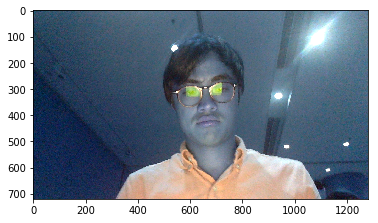

In [133]:
plt.imshow(example_frames[0])

In [136]:
output_eg = detect(example_frames[0])

Using CPU

tensor([[163.05937,  48.23519, 268.41467, 180.11566,   0.97525,   1.00000,   0.00000]], grad_fn=<IndexBackward>)


/Users/See/anaconda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


502.0 115.0 826.0 520.0


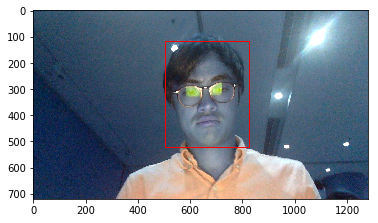

In [137]:
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
plt.imshow(example_frames[0])

for detection in output_eg:
    x1, y1, x2, y2 = detection[:4]
    print(x1, y1, x2, y2)
    # Create a Rectangle patch
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [138]:
webcam.release()